In [ ]:

!pip install Konlpy > /dev/null

In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 네이버 영화 리뷰 데이터로 검색
train_df = pd.read_csv('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt', sep='\t')
test_df = pd.read_csv('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt', sep='\t')

In [ ]:
print(train_df.shape, test_df.shape)
train_df.head(3)

(150000, 3) (50000, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [ ]:
# Null 데이터가 있는지 확인
train_df.isna().sum()

id          0
document    5
label       0
dtype: int64

In [ ]:
# Null 데이터 제거
train_df.dropna(how='any', inplace=True) 
train_df.shape

(149995, 3)

In [ ]:

# 중복여부 확인
train_df.document.nunique()

146182

In [ ]:

# 중복 데이터 제거
train_df.drop_duplicates(subset=['document'], inplace=True) 
train_df.shape

(146182, 3)

In [ ]:

# 긍정(1)/부정(0) 분포
train_df.label.value_counts()

0    73342
1    72840
Name: label, dtype: int64

In [ ]:
test_df.isna().sum()

id          0
document    3
label       0
dtype: int64

In [ ]:

test_df.dropna(how='any', inplace=True)

In [ ]:

test_df.document.nunique()

49157

In [ ]:

test_df.drop_duplicates(subset=['document'], inplace=True)
test_df.shape

(49157, 3)

In [ ]:

test_df.label.value_counts()

1    24711
0    24446
Name: label, dtype: int64

### 2. 텍스트 전처리
- train dataset

In [ ]:
train_df.document = train_df.document.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ').str.strip()
train_df.head(3)

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [ ]:
train_df.document.replace('', np.nan, inplace=True)
train_df.document.isna().sum()

789

In [ ]:
train_df.dropna(how='any', inplace=True)
train_df.shape

(145393, 3)

In [ ]:
test_df.document = test_df.document.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ').str.strip()
test_df.document.replace('', np.nan, inplace=True)
test_df.dropna(how='any', inplace=True)
test_df.shape

(48852, 3)

In [ ]:

train_df.to_csv('naver_movie_train_전처리완료.tsv', sep='\t', index=False)
test_df.to_csv('naver_movie_test_전처리완료.tsv', sep='\t', index=False)

### 3. 한글 형태소 분석

In [ ]:
from konlpy.tag  import Okt
okt = Okt()

In [ ]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','을','ㅋㅋ','ㅠㅠ','ㅎㅎ']


In [ ]:
from tqdm.notebook import tqdm

X_train = []
for sentence in tqdm(train_df.document):
    morphs = okt.morphs(sentence, stem=True)
    tmp_x = [word for word in morphs if word not in stopwords]
    X_train.append(tmp_x)

  0%|          | 0/145393 [00:00<?, ?it/s]

In [ ]:
X_train[:3]

[['아', '더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]

### 4. Keras Tokenizer --> Train/Test dataset
 - 수업중 시간 관계상 train dataset을 train/test dataset을 분할해서 사용

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts(X_train)

In [ ]:
len(t.word_index)

43118

In [ ]:
# 빈도수 상위 20,000개 단어로 인코딩
num_words = 20000
t = Tokenizer(num_words=num_words)
t.fit_on_texts(X_train)

In [ ]:
len(t.word_index)

43118

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import reuters
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_train, train_df.label, stratify=train_df.label, test_size=0.2,
    random_state=seed
)

In [ ]:
X_train = t.texts_to_sequences(X_train)
X_test = t.texts_to_sequences(X_test)

In [ ]:
# 데이터 최대/평균 길이
max(len(s) for s in X_train), sum(map(len, X_train)) / len(X_train)

(70, 10.594717746788865)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = 40
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)
X_train.shape, X_test.shape

((116314, 40), (29079, 40))

### 5. LSTM 모델 정의 / 설정 / 학습

In [ ]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
model = Sequential([
    Embedding(num_words, 120, input_length=max_len),
    LSTM(128),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 120)           2400000   
                                                                 
 lstm (LSTM)                 (None, 128)               127488    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2,527,617
Trainable params: 2,527,617
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile('adam', 'binary_crossentropy', ['accuracy'])
model_path = 'best-naver-movie-lstm.h5'
mc = ModelCheckpoint(model_path, verbose=1, best_save_only = True)
es = EarlyStopping(patience=5)

hist = model.fit(X_train, y_train, validation_split = 0.2,
          epochs = 100, batch_size = 128, 
          callbacks=[mc, es])

Epoch 1/100
725/727 [============================>.] - ETA: 0s - loss: 0.4034 - accuracy: 0.8144
Epoch 1: saving model to best-naver-movie-lstm.h5
727/727 [==============================] - 20s 11ms/step - loss: 0.4033 - accuracy: 0.8145 - val_loss: 0.3644 - val_accuracy: 0.8390
Epoch 2/100
724/727 [============================>.] - ETA: 0s - loss: 0.3105 - accuracy: 0.8681
Epoch 2: saving model to best-naver-movie-lstm.h5
727/727 [==============================] - 6s 9ms/step - loss: 0.3106 - accuracy: 0.8680 - val_loss: 0.3602 - val_accuracy: 0.8420
Epoch 3/100
726/727 [============================>.] - ETA: 0s - loss: 0.2590 - accuracy: 0.8922
Epoch 3: saving model to best-naver-movie-lstm.h5
727/727 [==============================] - 7s 10ms/step - loss: 0.2590 - accuracy: 0.8921 - val_loss: 0.3709 - val_accuracy: 0.8445
Epoch 4/100
727/727 [==============================] - ETA: 0s - loss: 0.2137 - accuracy: 0.9123
Epoch 4: saving model to best-naver-movie-lstm.h5
727/727 [=======

In [ ]:
best_model = load_model(model_path)
best_model.evaluate(X_test, y_test)

909/909 [==============================] - 4s 4ms/step - loss: 0.5478 - accuracy: 0.8305


[0.5478254556655884, 0.830461859703064]

In [ ]:
y_acc = hist.history['accuracy']
y_loss = hist.history['loss']
xs = np.arange(1, len(y_acc) + 1)

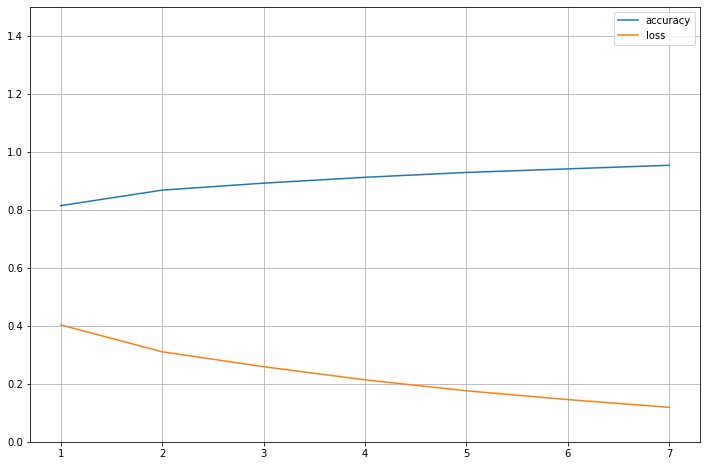

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.plot(xs, y_acc, label='accuracy')
plt.plot(xs, y_loss, label='loss')
plt.legend(), plt.grid()
plt.ylim([0, 1.5])
plt.show()

### 6. 실제 데이터 예측

In [ ]:
review = '이 영화 개꿀잼 ㅋㅋㅋㅋ'

In [ ]:
import re
reveiw = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣]', '', review).strip()
review

'이 영화 개꿀잼 ㅋㅋㅋㅋ'

In [ ]:
morphs = okt.morphs(review, stem=True)
review = [word for word in morphs if word not in stopwords]
encoded = t.texts_to_sequences([review])
padded = pad_sequences(encoded, maxlen = max_len)
scroe = best_model.predict(padded)

In [ ]:
score = scroe

In [ ]:
score = float(best_model.predict(padded))
print('긍정' if score > 0.5 else '부정')

긍정


In [ ]:
def sentiment_predict(review, tokenizer=t, max_len=max_len):
    morphs = okt.morphs(review, stem=True)
    review = [word for word in morphs if word not in stopwords]
    encoded = t.texts_to_sequences([review])
    padded = pad_sequences(encoded, maxlen = max_len)
    score = float(best_model.predict(padded))
    return '긍정' if score > 0.5 else '부정'

In [ ]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋㅋ')

'긍정'

In [ ]:
sentiment_predict('이 영화 핵노잼 ㅠㅠ')

'부정'

In [ ]:
sentiment_predict('이딴게 영화냐 ㅋㅋㅋㅋ')

'부정'

7. 학습과정 시각화

In [ ]:
y_acc = hist.history['accuracy']
y_loss = hist.history['loss']
y_vacc = hist.history['val_accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc) + 1)

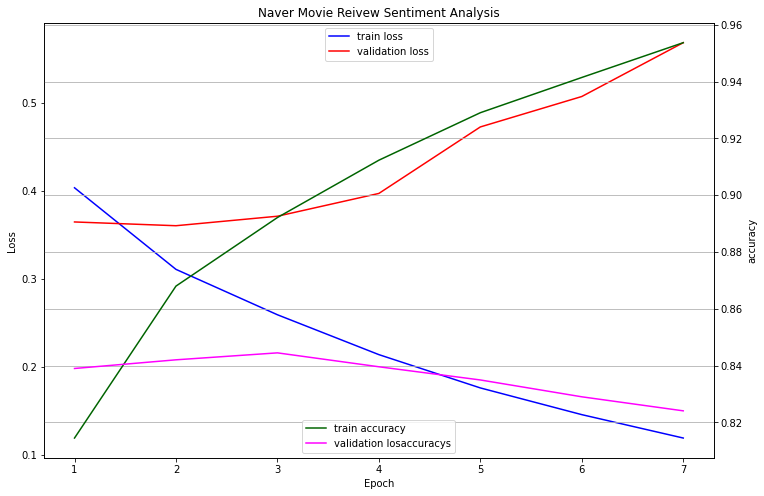

In [ ]:
# X축은 공유
# y축의 좌측 : loss, y축의 우측: accuracy
import matplotlib.pyplot as plt 

fig, ax0 = plt.subplots(figsize=(12,8))
ax1 = ax0.twinx()
ax0.plot(xs, y_loss, c='blue',label='train loss')
ax0.plot(xs, y_vloss, c='red',label='validation loss')
ax0.set_ylabel('Loss')
ax0.set_xlabel('Epoch')

ax1.plot(xs, y_acc, c='darkgreen',label='train accuracy')
ax1.plot(xs, y_vacc, c='magenta',label='validation losaccuracys')
ax1.set_ylabel('accuracy')

ax0.legend(loc = 'upper center'), ax1.legend(loc = 'lower center')
plt.title('Naver Movie Reivew Sentiment Analysis')
plt.grid();
plt.show()

### 8. Conv1D + GRU

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dropout

In [ ]:
model2 = Sequential([
    Embedding(num_words, 120, input_length = max_len),
    Dropout(0.5),
    Conv1D(64, 5, activation='relu'),
    MaxPooling1D(5),
    GRU(128),
    Dense(1, activation='sigmoid')
])

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 40, 120)           2400000   
                                                                 
 dropout_2 (Dropout)         (None, 40, 120)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 36, 64)            38464     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 64)            0         
 1D)                                                             
                                                                 
 gru_1 (GRU)                 (None, 128)               74496     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                      

In [ ]:
model2.compile('adam', 'binary_crossentropy', ['accuracy'])
model2_path = 'best-imdb-conv1d-LSTM.h5'
mc = ModelCheckpoint(model2_path, verbose=1, best_save_only = True)
es = EarlyStopping(patience=2)

hist2 = model2.fit(X_train, y_train, validation_split = 0.2,
          epochs = 100, batch_size = 128, 
          callbacks=[mc, es])

Epoch 1/100
727/727 [==============================] - ETA: 0s - loss: 0.4622 - accuracy: 0.7692
Epoch 1: saving model to best-imdb-conv1d-LSTM.h5
727/727 [==============================] - 10s 9ms/step - loss: 0.4622 - accuracy: 0.7692 - val_loss: 0.4087 - val_accuracy: 0.8085
Epoch 2/100
722/727 [============================>.] - ETA: 0s - loss: 0.3665 - accuracy: 0.8318
Epoch 2: saving model to best-imdb-conv1d-LSTM.h5
727/727 [==============================] - 6s 8ms/step - loss: 0.3665 - accuracy: 0.8318 - val_loss: 0.4090 - val_accuracy: 0.8103
Epoch 3/100
722/727 [============================>.] - ETA: 0s - loss: 0.3117 - accuracy: 0.8605
Epoch 3: saving model to best-imdb-conv1d-LSTM.h5
727/727 [==============================] - 6s 8ms/step - loss: 0.3119 - accuracy: 0.8605 - val_loss: 0.4275 - val_accuracy: 0.8054


In [ ]:
best_model2 = load_model(model2_path)
best_model2.evaluate(X_test, y_test)

909/909 [==============================] - 3s 3ms/step - loss: 0.4248 - accuracy: 0.8050


[0.42483627796173096, 0.8049795627593994]

In [ ]:
y_acc2 = hist2.history['accuracy']
y_loss2 = hist2.history['loss']
y_vacc2 = hist2.history['val_accuracy']
y_vloss2 = hist2.history['val_loss']
xs2 = np.arange(1, len(y_acc2) + 1)

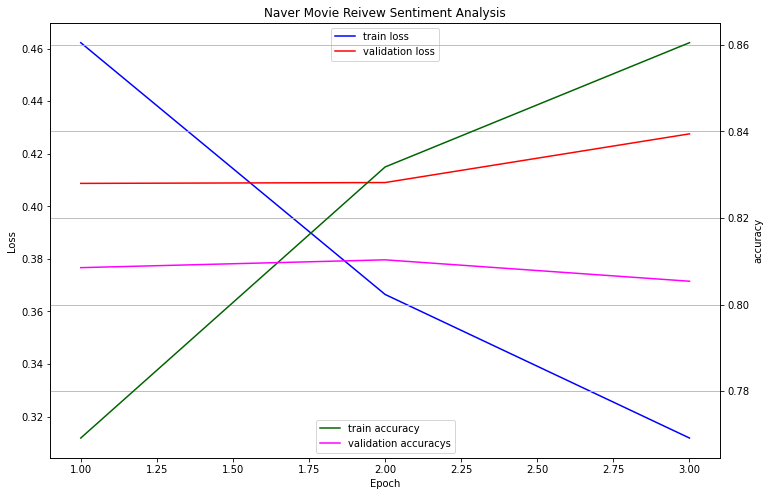

In [ ]:
# X축은 공유
# y축의 좌측 : loss, y축의 우측: accuracy
import matplotlib.pyplot as plt 

fig, ax0 = plt.subplots(figsize=(12,8))
ax1 = ax0.twinx()
ax0.plot(xs2, y_loss2, c='blue',label='train loss')
ax0.plot(xs2, y_vloss2, c='red',label='validation loss')
ax0.set_ylabel('Loss')
ax0.set_xlabel('Epoch')

ax1.plot(xs2, y_acc2, c='darkgreen',label='train accuracy')
ax1.plot(xs2, y_vacc2, c='magenta',label='validation accuracys')
ax1.set_ylabel('accuracy')

ax0.legend(loc = 'upper center'), ax1.legend(loc = 'lower center')
plt.title('Naver Movie Reivew Sentiment Analysis')
plt.grid();
plt.show()